In [1]:
import numpy as np
import gym
import tensorflow as tf
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

learning_rate = 0.001
epochs_number = 10000
batch_size = 256
replay_buffer_size = 256*8

env_name = 'MountainCar-v0'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

# observations = envs.reset()
# for t in range(100):
#     # print(envs.render(mode='human'))
#     actions = np.stack([envs.action_space.sample() for _ in range(nproc)])
#     observations, rewards, done, info = envs.step(actions)
    

## Create model architecture

In [3]:
tf.reset_default_graph()

state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
print(state_ph)
random_ph = tf.expand_dims(tf.random.normal(tf.gather_nd(tf.shape(state_ph), [[0]])), axis=-1)
print(random_ph)
input_l = tf.concat([state_ph, random_ph], axis=1)

l1 = tf.layers.dense(input_l, units=32, activation=tf.nn.relu)
output_linear = tf.layers.dense(l1, units=action_space)

output = tf.nn.softmax(output_linear)
action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
#action_op = tf.expand_dims(tf.constant(1), axis=0)

output_log = tf.nn.log_softmax(output_linear)

weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
action_ph = tf.placeholder(shape=[None], dtype=tf.int32)


action_one_hot = tf.one_hot(action_ph, action_space)
responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
loss = -tf.reduce_mean(responsible_output_log * weight_ph)

gradients = tf.gradients(loss, tf.trainable_variables())

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
update = optimizer.minimize(loss)

W0714 23:14:50.349673 12248 deprecation.py:323] From <ipython-input-3-1f4d0d6654ce>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0714 23:14:50.352676 12248 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("Placeholder:0", shape=(?, 2), dtype=float32)
Tensor("ExpandDims:0", shape=(?, 1), dtype=float32)


W0714 23:14:50.557086 12248 deprecation.py:323] From <ipython-input-3-1f4d0d6654ce>:13: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.


In [4]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

# sess.run(loss, feed_dict={weight_ph: [0, 1, 2],
#                           action_ph: [1, 2, 3],
#                           state_ph: [[1,2], [1,2], [1,2]]})

In [5]:
def make_reward_to_go(reward):
    return np.cumsum(reward[::-1])[::-1]

make_reward_to_go(np.arange(1, 5))

array([10,  9,  7,  4], dtype=int32)

#TODO: подумать о последствиях слишком большого количества сэмплов в начале (решил рассинхронизацией)

In [6]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    replay_buffer = np.empty((0,3), np.float32)
    
    # [state, action, weight] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(action_op, feed_dict={state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            if dones.any():
                if dones.all():
                    print('WARNING: envs are in sync!!')
                
                done_indexes = np.arange(envs_number)[dones]
                for i in done_indexes:
                    #print(dones, i, len(rollouts[i][:, 2]))
                    history['reward'].append(rollouts[i][:, 2].sum())

                    rollouts[i][:, 2] = make_reward_to_go(rollouts[i][:, 2])
                    replay_buffer = np.append(replay_buffer, rollouts[i], axis=0)
                    rollouts[i] = np.empty((0, 3))
                #history['reward'] = [np.mean(history['reward'])]
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history
   
a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-0.40867016,  0.00438747], dtype=float32), 1, -33.0],
       [array([-6.422737e-01, -5.099893e-04], dtype=float32), 0, -70.0],
       [array([-0.5558407 ,  0.00681376], dtype=float32), 2, -52.0],
       [array([-0.6658653 ,  0.00323729], dtype=float32), 0, -12.0],
       [array([-0.6347436 ,  0.00908973], dtype=float32), 0, -7.0],
       [array([-0.3987887 ,  0.00188263], dtype=float32), 0, -29.0],
       [array([-0.41825902,  0.00497838], dtype=float32), 2, -35.0],
       [array([-0.58512115,  0.00831314], dtype=float32), 0, -56.0]],
      dtype=object)

In [7]:
from tqdm import tqdm_notebook

history = {'reward': [], 'loss': [], 'gradients_max_abs': [], 'gradients_equal_zero': []}
batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)
# Makes them of equal lenght
for i in range(10):
    next(batch_generator)

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    
    _, loss_, gradients_ = sess.run([update, loss, gradients], feed_dict={state_ph: np.array(batch[:, 0].tolist()),
                                                    action_ph: batch[:, 1],
                                                    weight_ph: batch[:, 2]})
    
    history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
    history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))
    
    history['loss'].append(loss_)


## Plot results

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

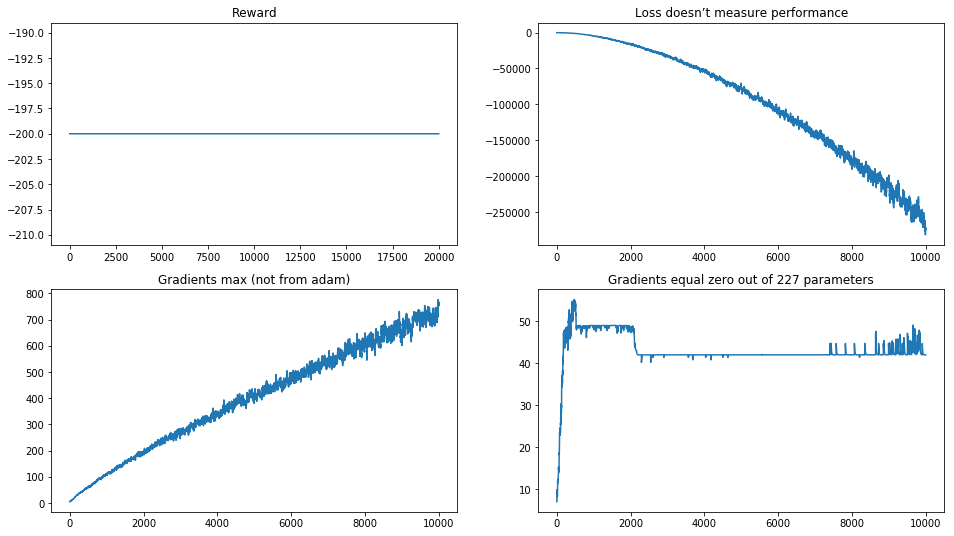

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['loss'], 'Loss doesn’t measure performance', axs[0, 1])
plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])

parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plt.savefig('logs/MountainCar-v0 drunk (given random numbers)')

### This represents need for Advantage Estimation

## Our agent

In [14]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions, out, out_log = sess.run([action_op, output, output_log], feed_dict={state_ph: [observations]})
    print(out, out_log)
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')


[[0. 1. 0.]] [[ -909.129      0.     -1670.6931]]
[[0. 0. 1.]] [[ -993.2202 -2077.296      0.    ]]
[[0. 1. 0.]] [[-3354.2686     0.     -6268.5605]]
[[0. 0. 1.]] [[ -531.40137 -1091.0283      0.     ]]
[[0. 1. 0.]] [[-3552.3813     0.     -6641.235 ]]
[[0. 0. 1.]] [[-3304.2585 -7012.218      0.    ]]
[[0. 0. 1.]] [[-2368.8186 -5015.8604     0.    ]]
[[0. 1. 0.]] [[ -5921.854      0.    -11097.157]]
[[0. 0. 1.]] [[ -913.5037 -1907.8862     0.    ]]
[[0. 0. 1.]] [[ -865.86273 -1806.3567      0.     ]]
[[0. 1. 0.]] [[ -6856.2075      0.     -12853.195 ]]
[[0. 0. 1.]] [[-1564.0848 -3298.1782     0.    ]]
[[0. 0. 1.]] [[-1943.154 -4108.103     0.   ]]
[[0. 1. 0.]] [[-4853.4536     0.     -9089.496 ]]
[[0. 0. 1.]] [[-2494.0513 -5285.3633     0.    ]]
[[0. 0. 1.]] [[ -5686.0728 -12067.068       0.    ]]
[[0. 0. 1.]] [[-3207.229 -6806.215     0.   ]]
[[0. 0. 1.]] [[-1844.6031 -3899.266      0.    ]]
[[0. 1. 0.]] [[-3790.0034     0.     -7091.3076]]
[[0. 0. 1.]] [[-2273.6587 -4816.4023     0. 

KeyboardInterrupt: 

## Random agent

In [11]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = [envs.action_space.sample() for i in range(envs.num_envs)]
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

Done
Done
Done
Done
Done
